This notebook shows how the silhouette score decreases as we increase the number of clusters, and as we smooth out the closing price data with a rolling average

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import metrics

In [3]:
def get_rolling_average(dataframe,nodays):
    dfnew = dataframe.copy()
    cols = dfnew.columns
    for c in cols:
        dfnew[c]=dfnew[c].rolling(nodays,center=True).mean()
    dfnew = dfnew.dropna(axis='rows')
    return dfnew

In [4]:
def prices_to_perc_change(prices):
    return [100*(prices[i+1]-prices[i])/prices[i] for i in range(len(prices)-1)]

def convert_to_perc(dataframe):
    return pd.DataFrame({t:prices_to_perc_change(closing_prices[t]) for t in closing_prices.columns})

There may be external factors that force all prices to change more than they normally would on certain days; we can eliminate that variation by normalizing the rows wrt to the L1 norm.

In [5]:
def l1_row_normalization(dataframe):
    dft = dataframe.T.copy()
    maxpercchanges = {i:max((dft[i].apply(abs)).values) for i in dft.columns}
    for i in dft.columns:
        dft[i] = dft[i]/maxpercchanges[i]
    return dft.T

def convert_perc_normalized(dataframe):
    return l1_row_normalization(convert_to_perc(dataframe))

In [6]:
def normalize(dataframe):
    dfn = dataframe.copy()
    for ticker in dfn:
        dfn[ticker] = dfn[ticker]/np.linalg.norm(dfn[ticker])
    return dfn

def normalize_transpose(dataframe):
    return normalize(dataframe).T

In [8]:
closing_prices = pd.read_pickle("./data/stocks/closing_prices.pkl")

dfs = [normalize_transpose(get_rolling_average(closing_prices,d)) for d in [3,5,7]]
silhouette_scores = [[] for d in [3,5,7]]
noclusters = [i for i in range(3,61)]
for i in noclusters:
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    for j in [0,1,2]:
        df = dfs[j]
        ypred = kmeans.fit_predict(df)
        labels = kmeans.labels_
        #score = metrics.silhouette_score(df, labels, metric = 'euclidean')
        silhouette_scores[j].append(kmeans.inertia_)


C:\Users\safibn\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\safibn\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\safibn\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\safibn\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Wi

C:\Users\safibn\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\safibn\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\safibn\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\safibn\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Wi

C:\Users\safibn\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\safibn\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\safibn\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\safibn\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Wi

C:\Users\safibn\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\safibn\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\safibn\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\safibn\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Wi

C:\Users\safibn\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\safibn\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\safibn\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\safibn\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Wi

C:\Users\safibn\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\safibn\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\safibn\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\safibn\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Wi

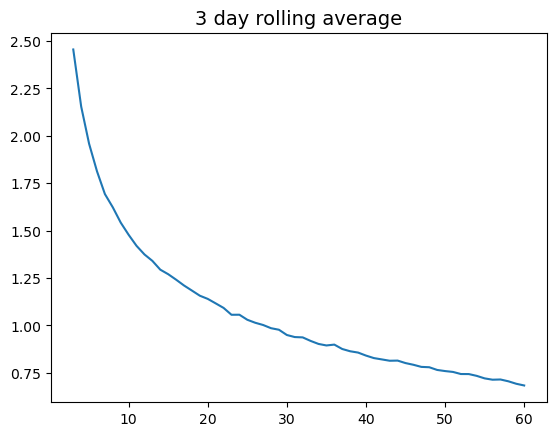

In [9]:
plt.plot(noclusters, silhouette_scores[0])
plt.title("3 day rolling average", fontsize=14)

plt.show()

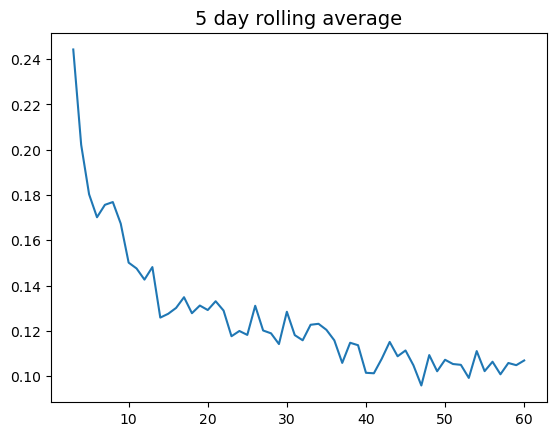

In [9]:
plt.plot(noclusters, silhouette_scores[1])
plt.title("5 day rolling average", fontsize=14)

plt.show()

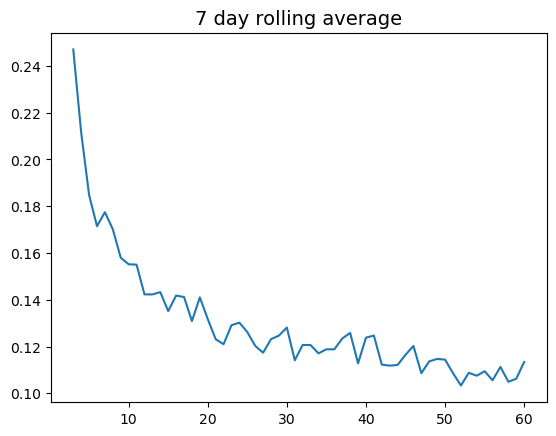

In [10]:
plt.plot(noclusters, silhouette_scores[2])
plt.title("7 day rolling average", fontsize=14)

plt.show()

In [12]:
labels

array([ 5,  3,  8,  6,  3,  5,  4, 13,  2,  0,  5,  7,  6,  0,  1, 14, 14,
        9,  1,  8,  5,  7,  8,  7,  5,  7, 10, 12, 10,  1, 13, 10, 10,  6,
       15, 13,  0,  9,  9,  3, 13,  7,  7,  1,  3,  7,  3,  0, 10,  8,  6,
        8, 15,  6,  9,  0,  1,  5,  5,  5,  3, 13,  1, 16,  8,  8,  6,  0,
        1, 15,  7,  9, 13,  3,  5,  4,  3,  3,  0,  1,  7, 15,  1, 10, 15,
        3, 15,  4,  0, 16,  0,  3,  1,  0,  0,  3,  5,  8,  6, 13,  5, 14,
        0,  6,  7,  6,  3, 13,  6,  3,  3,  1, 14,  8,  3, 10,  8,  3,  8,
        3, 14, 10, 13,  8,  0,  0,  9,  7,  1, 10, 15,  3,  0,  2,  8,  6,
        5,  7,  6, 15,  7,  6, 12,  9,  5,  8,  0,  0,  1, 10,  2, 10, 10,
        0,  1,  1, 10, 10,  0,  1,  7,  1,  3,  8,  9,  8,  6,  7,  0, 11,
       10, 13, 14,  0,  1, 15, 15, 15,  2,  2,  3, 10, 10,  8, 15, 15, 10,
        6,  0,  6,  7,  3,  6,  7, 14,  9, 10,  5,  3,  7,  2, 15,  9,  0,
        1,  1,  1,  1,  3,  6, 13, 12,  6,  7, 10,  1, 10,  6,  6,  0,  6,
       13,  6,  0,  9,  5

In [13]:
df

Date,2022-11-01 00:00:00-04:00,2022-11-02 00:00:00-04:00,2022-11-03 00:00:00-04:00,2022-11-04 00:00:00-04:00,2022-11-07 00:00:00-05:00,2022-11-08 00:00:00-05:00,2022-11-09 00:00:00-05:00,2022-11-10 00:00:00-05:00,2022-11-11 00:00:00-05:00,2022-11-14 00:00:00-05:00,...,2023-10-16 00:00:00-04:00,2023-10-17 00:00:00-04:00,2023-10-18 00:00:00-04:00,2023-10-19 00:00:00-04:00,2023-10-20 00:00:00-04:00,2023-10-23 00:00:00-04:00,2023-10-24 00:00:00-04:00,2023-10-25 00:00:00-04:00,2023-10-26 00:00:00-04:00,2023-10-27 00:00:00-04:00
MMM,0.071024,0.070465,0.070378,0.070723,0.071198,0.071006,0.071855,0.073305,0.074672,0.075065,...,0.053999,0.053942,0.053365,0.052562,0.052001,0.052614,0.053184,0.053796,0.053274,0.053300
AOS,0.051255,0.051127,0.051560,0.052569,0.053072,0.052780,0.053525,0.054791,0.056193,0.056542,...,0.068172,0.067601,0.066043,0.064396,0.063734,0.063616,0.063148,0.064017,0.064390,0.065760
ABT,0.059199,0.058702,0.058454,0.058746,0.059383,0.059661,0.060606,0.061495,0.062004,0.061787,...,0.056083,0.057039,0.057703,0.058649,0.058694,0.058566,0.057911,0.057545,0.057145,0.057029
ABBV,0.060523,0.060249,0.060023,0.060518,0.061086,0.061410,0.061634,0.061859,0.062429,0.062888,...,0.063908,0.064098,0.063852,0.063428,0.062773,0.062887,0.062747,0.062815,0.061754,0.061269
ACN,0.060085,0.058148,0.056691,0.056449,0.057320,0.057699,0.058986,0.060496,0.062108,0.062512,...,0.066694,0.066835,0.066660,0.065841,0.065197,0.064698,0.064383,0.064172,0.063731,0.063733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,0.056827,0.057028,0.057611,0.058436,0.058899,0.058942,0.059203,0.059355,0.059443,0.059312,...,0.058051,0.058724,0.059069,0.059152,0.058788,0.058681,0.058740,0.058738,0.058662,0.058590
ZBRA,0.058106,0.053818,0.053224,0.053250,0.053812,0.053530,0.054838,0.057042,0.058928,0.059555,...,0.048697,0.048865,0.048177,0.047529,0.047235,0.047229,0.046797,0.046761,0.046859,0.047692
ZBH,0.055457,0.054136,0.052972,0.052945,0.053080,0.053233,0.054128,0.055682,0.056938,0.057308,...,0.053038,0.053356,0.053315,0.052974,0.052802,0.052807,0.052652,0.052310,0.052033,0.051994
ZION,0.080533,0.078523,0.077550,0.077771,0.079134,0.079320,0.081635,0.084336,0.086246,0.085848,...,0.059017,0.059633,0.057608,0.053876,0.050772,0.049462,0.049281,0.049501,0.049275,0.049468
